## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [2]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [5]:
from nndl import Softmax

In [6]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [16]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [17]:
print(loss)

2.3277607028048966


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

Beacuse the weights are randomly initialized and are not yet trained, so their output will predict randomly one of the 10 classes, so the probability for guessing correct class will be 0.1,
Softmax loss for this should be -ln(0.1) = ln(10) $\approx$ 2.3

#### Softmax gradient

In [47]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -3.647501 analytic: -3.647501, relative error: 5.572790e-09
numerical: 0.451700 analytic: 0.451700, relative error: 2.844425e-08
numerical: -3.732429 analytic: -3.732429, relative error: 1.804868e-08
numerical: 0.647963 analytic: 0.647963, relative error: 6.568576e-08
numerical: -1.820191 analytic: -1.820191, relative error: 2.507468e-08
numerical: 1.109531 analytic: 1.109531, relative error: 1.441653e-09
numerical: -5.199350 analytic: -5.199350, relative error: 5.170286e-09
numerical: 0.594704 analytic: 0.594704, relative error: 4.507831e-09
numerical: 1.727080 analytic: 1.727080, relative error: 1.661232e-08
numerical: 1.027455 analytic: 1.027455, relative error: 7.851578e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [22]:
import time

In [83]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.321937839839383 / 355.5657032496941 computed in 0.04790449142456055s
Vectorized loss / grad: 2.321937839839384 / 355.5657032496941 computed in 0.002991199493408203s
difference in loss / grad: -8.881784197001252e-16 /3.2759122096389006e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

Both uses gradient descent.

iteration 0 / 1500: loss 2.340083207460104
iteration 100 / 1500: loss 2.0796101858228555
iteration 200 / 1500: loss 1.9509828239589024
iteration 300 / 1500: loss 1.9094554741811902
iteration 400 / 1500: loss 1.9249155589928528
iteration 500 / 1500: loss 1.8564142779293118
iteration 600 / 1500: loss 1.955236276552195
iteration 700 / 1500: loss 1.8739863809177661
iteration 800 / 1500: loss 1.8282954997114702
iteration 900 / 1500: loss 1.8613853134130016
iteration 1000 / 1500: loss 1.801377358060681
iteration 1100 / 1500: loss 1.838523870326722
iteration 1200 / 1500: loss 1.93128662446051
iteration 1300 / 1500: loss 1.8633359921607544
iteration 1400 / 1500: loss 1.7841174341843271
That took 5.049999237060547s


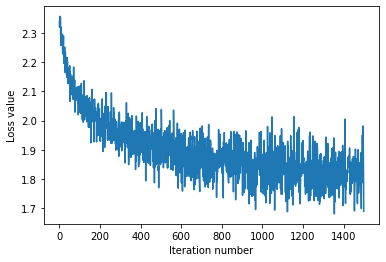

In [87]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [88]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.38042857142857145
validation accuracy: 0.386


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [75]:
np.finfo(float).eps

2.220446049250313e-16

In [82]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
from collections import defaultdict
lrs = [1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10]
lrs_metrics = defaultdict(list) #training error, val error, test_error
for lr in lrs:
    print("Learning rate: ",lr)
    softmax = Softmax(dims=[num_classes, num_features])
    loss_hist = softmax.train(X_train, y_train, learning_rate=lr,
                      num_iters=1500, verbose=True)
    y_train_pred = softmax.predict(X_train)
    train_acc = np.mean(np.equal(y_train,y_train_pred))
    y_val_pred = softmax.predict(X_val)
    val_acc = np.mean(np.equal(y_val,y_val_pred))
    y_test_pred = softmax.predict(X_test)
    test_acc = np.mean(np.equal(y_test,y_test_pred))
    
    lrs_metrics[lr].append(train_acc)
    lrs_metrics[lr].append(val_acc)
    lrs_metrics[lr].append(test_acc)
                         
best_val = 0
for k,v in lrs_metrics.items():
    print("lr: ",k,"train acc: ",v[0],"val acc: ",v[1])
    if best_val<v[1]:
        best_val=v[1]
        best_lr = k
        best_test = v[2]

print("Best lr: ",best_lr)
print("Best val acc: ", best_val, "Best val err: ", 1-best_val)
print("Best test acc: ",best_test, "Best test err: ",1-best_test)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


Learning rate:  0.001
iteration 0 / 1500: loss 2.2835571027153025
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
Learning rate:  0.0001
iteration 0 / 1500: loss 2.3741269036684773
iteration 100 / 1500: loss 21.566058045533524
iteration 200 / 1500: loss 21.58936956028798
iteration 300 / 1500: loss 23.002643868236717
iteration 400 / 1500: loss 28.245920728779094
iteration 500 / 1500: loss 25.92942062535044
iteration 600 / 1500: loss 19.075525790192017
iteration 700 / 1500: loss 23.70727229305301
iteration 800 / 1500: loss 22.159543997997456
iteration 900 / 1500: loss 19.685382694143737
iteration 1000 / 